In [4]:
# Will Cheney 13-01-2021
# Script to generate visual representation of protein sequence
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import csv
import os


In [8]:
# Test Sequence
p53 = 'MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELPPGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPGGSRAHSSHLKSKKGQSTSRHKKLMFKTEGPDSD'

In [10]:

def calculate_vertices(sides):
    """
    caluculates (x,y) vertices coordinates for equal length n-sided shape
    Parameters: 
        sides: number of  sides
    Returns: List of (x,y) coordinates of the vertices
    E.g. sides = 4 will return four points [(1,0),(0,1),(-1,0),(0,-1)] which define the vertices of the shape
    """
    i = 1
    vertices = []
    center = (0,0)
    while (i * 360/sides) <= 360:
        vertices.append((round((center[0] + math.sin(math.radians(i * 360/sides))),4), round((center[1] + math.cos(math.radians(i * 360/sides))),4)))
        i += 1

    return vertices

def get_variant_sequence(protein_seq, mutation):
    """
    Modifies a protein sequence with mutation in format(A25T)
    Paramerters:
        protein_seq: unmutated protein sequence
        mutation: mutation to be introduced in format A25T
    Returns: Protein sequence string with introduced mutation
    """
    mutation = list(mutation)
    result = protein_seq[0:(int(''.join( mutation[1: len(mutation)-1])) - 1)] + mutation[-1] + protein_seq[int(mutation[1]):]
    return result

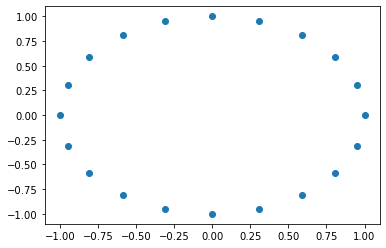

In [153]:
#Verify calculate_vertices is working
test_list = calculate_vertices(20)
res = [[ i for i, j in test_list ], 
       [ j for i, j in test_list ]] 
plt.scatter(res[0], res[1])
plt.show()

In [5]:
#Load amino acid distance matrix, these will be used to calculate step size when drawing proteins

g_distance_index = ['S','R', 'L', 'P', 'T', 'A', 'V', 'G', 'I', 'F', 'Y', 'C', 'H', 'Q', 'N', 'K', 'D', 'E', 'M', 'W'] #Add serine d/max distance
g_distance_matrix = np.array([[1, 110, 145, 74, 58, 99, 124, 56, 142, 155, 144, 112, 89, 68, 46, 121, 65, 80, 135, 177],
                            [None, 1, 102, 103, 71, 112, 96, 125, 97, 97, 77, 180, 29, 43, 86, 26, 96, 54, 91, 101],
                            [None, None, 1, 98, 92, 96, 32, 138, 5, 22, 36, 198, 99, 113, 153, 107, 172, 138, 15, 61],
                            [None, None, None, 1, 38, 27, 68, 42, 95, 114, 110, 169, 77, 76, 91, 103, 108, 93, 87, 147],
                            [None, None, None, None, 1, 58, 69, 59, 89, 103, 92, 149, 47, 42, 65, 78, 85, 65, 81, 128],
                            [None, None, None, None, None, 1, 64, 60, 94, 113, 112, 195, 86, 91, 111, 106, 126, 107, 84, 148],
                            [None, None, None, None, None, None, 1, 109, 29, 50, 55, 192, 84, 96, 133, 97, 152, 121, 21, 88],
                            [None, None, None, None, None, None, None, 1, 135, 153, 147, 159, 98, 87, 80, 127, 94, 98, 127, 184],
                            [None, None, None, None, None, None, None, None, 1, 21, 33, 198, 94, 109, 149, 102, 168, 134, 10, 61],
                            [None, None, None, None, None, None, None, None, None, 1, 22, 205, 100, 116, 158, 102, 177, 140, 28, 40],
                            [None, None, None, None, None, None, None, None, None, None, 1, 194, 83, 99, 143, 85, 160, 122, 36, 37],
                            [None, None, None, None, None, None, None, None, None, None, None, 1, 174, 154, 139, 202, 154, 170, 196, 215],
                            [None, None, None, None, None, None, None, None, None, None, None, None, 1, 24, 68, 32, 81, 40, 87, 115],
                            [None, None, None, None, None, None, None, None, None, None, None, None, None, 1, 46, 53, 61, 29, 101,130],
                            [None, None, None, None, None, None, None, None, None, None, None, None, None, None, 1, 94, 23, 42, 142, 174],
                            [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 1, 101, 56, 95, 110],
                            [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 1, 45, 160, 181],
                            [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 1, 126, 152],
                            [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 1, 67],
                            [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 1]])




In [12]:
def generate_cgr(protein_seq, distance_matrix = g_distance_matrix , vertices_labels = g_distance_index, step = 0.5):
    """
    Generates scatterplot points of a protein sequence by iterating chaos game represnetation of the protein sequence
    Step size at each iteration is calculated by step*(1 / sqrt(Grantham's distance)). The purpose of this is to add structure to the resultant image by introducing a stickiness
    
    Parameters:
        protein_seq -- An amino acid sequence from which to generate the image
        distance_matrix -- A 20x20 matrix which defines the similarity of any two amino acids
        vertices_labels -- 1x20 list which contains the labels for distance_matrix
        step -- indicates default step size
        
    Returns:
        stack -- a list of (x,y) coordinates representing the point at each step
        cat -- a list of labels used to annotate resultant image
    """
    
    
    
    assert step <= 1, "Step size too large, will over shoot vertex "
    
    
    protein_seq = protein_seq.strip('*').upper() # format input to remove termination factor and convert to uppercase
    
    mapped_vertices = {}
       
  
    cat = vertices_labels
        
        
    vertices = calculate_vertices(len(cat))
    for i in range(len(vertices)):
        for j in cat[i]:
            
            mapped_vertices[j] = vertices[i]
    
    stack = [(0,0)]
    prev_AA = 'M'
    
    for i in protein_seq:
        
        if i not in ['W', 'F', 'Y', 'Q', 'P', 'N', 'A', 'T', 'S', 'V', 'G', 'M', 'C', 'I', 'L','E', 'D', 'K', 'R', 'H']:
            continue
        
        destination = np.array(mapped_vertices[i])
        current_position = np.array(stack[-1])
        
 
        next_position = (destination - current_position)*(step * 1/np.sqrt(get_AA_distance(prev_AA, i, distance_matrix , vertices_labels))) + current_position
        prev_AA = i
                                                          
        stack.append((next_position[0], next_position[1]))
        
    return stack, cat

def get_AA_distance(AAone, AAtwo, distance_matrix, distance_index):
    '''
    Retrieves the distance value for a pair of amino acids
    
    Returns:
        distance value
    '''

    if distance_index.index(AAtwo) < distance_index.index(AAone):
        return distance_matrix.T[distance_index.index(AAone), distance_index.index(AAtwo)]
    
    else:
        return distance_matrix[distance_index.index(AAone), distance_index.index(AAtwo)]
    

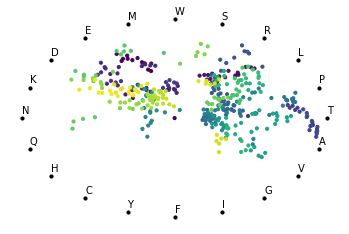

In [14]:
# We can now generate an image using generate_cgr() and matplotlib

stack, cat = generate_cgr(p53) #Get list of points for CGR of p53
stack = np.array(stack) 
colors = (np.array( range( len(stack)))/ len(stack)) * 100 # Colours points based on position with sequence

plt.scatter(stack[:,0], stack[:,1], s = 10, c = colors, cmap = 'viridis') #pass CGR points to plt.scatter
plt.axis('off')

vertices = np.array(calculate_vertices(len(cat)))
plt.scatter(vertices[:,0], vertices[:,1], color = 'k', s = 10) #show calculated vertices

fig1 = plt.gcf()

for i in range(len(vertices)):
    plt.annotate(cat[i], vertices[i] + [0, 0.05]) #label vertices

#fig1.savefig('p53', dpi = 300, bbox_inches='tight') #save resultant image
plt.show()

[ 20.  30.  40.  50.  60.  70.  80.  90. 100. 110.]


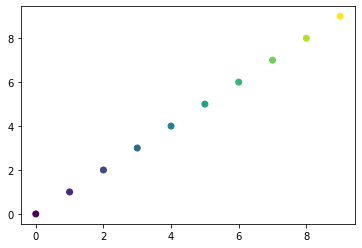

In [15]:
# How colour varies with distance
a = np.array(range(10))
colors = (np.array( range( len(a)))/ len(a)) * 100 +20 # Creates an array of values [0...100] to be passed to cmap, values are normalized to sequence length than scaled to 0-100
print(colors)
plt.scatter(a,a, c = colors ,cmap = 'viridis')
plt.show()

In [77]:
# data load for p53 missense mutation data
filename  = 'p53 Missense data.csv'
variants = []
labels = []
with open(filename) as file:
    reader = csv.reader(file)
    
    for row in reader:
        variants.append(row[0])
        labels.append(row[1])

for i in range(len(variants)):
    variants[i] = get_variant_sequence(p53, variants[i])
    

In [52]:
# Data load for pfam protein data
DIR = 'C:/Users/willc/Code/Protein CGR/pfam_RP15/'
sequences = [[], [], [], []] 
counter = 0
current_seq = ""

for filename in os.listdir(DIR):
    with open(os.path.join(DIR, filename)) as file:
        
        reader = csv.reader(file)
        
        for row in reader:
            
            if row[0][0] == '>':
                if not current_seq:
                    current_seq = ""
                    continue
                else:
                    sequences[counter].append(current_seq)
                    current_seq = ""
                    continue
                
            else:
                current_seq = current_seq + row[0]
                
        sequences[counter].append(current_seq) 
        current_seq = ""
        
        
    counter += 1
    
        

In [ ]:
#Generate and save multiple protein visualizations to build datasets
for k in range(len(sequences)):
    counter = 1
    for i in sequences[k][0:800]:
        stack, cat = generate_cgr(i, distance_matrix = 'None', step = 0.5)
        stack = np.array(stack)
        colors = (np.array( range( len(stack)))/ len(stack)) * 100 # Creates an array of values [0...100] to be passed to cmap, values are normalized to sequence length than scaled to 0-100

        plt.scatter(stack[:,0], stack[:,1], s = 10, c = colors, cmap = 'viridis')
        plt.axis('off')

        vertices = np.array(calculate_vertices(len(cat)))
        plt.scatter(vertices[:,0], vertices[:,1], color = 'k', s = 10)

        fig1 = plt.gcf()

        #for j in range(len(vertices)):
            #plt.annotate(cat[j], vertices[j] + [0, 0.05])
        
        fig1.savefig('softmax_' + str(counter) +'_' + str(k), dpi = 300, bbox_inches='tight')
        fig1.clf()
        plt.clf()
        counter += 1

    